In [1]:
import random
import numpy as np
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler, DDIMScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
import warnings
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Not a best practice but adding ignoring warnings to remove constant macOS warnings about MPS
warnings.filterwarnings("ignore")

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
cast_device = "cuda" if torch.cuda.is_available() else "cpu"
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu"

NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# Attention slicing - improves performance on macOS
if torch.has_mps:
    slice_size = unet.config.attention_head_dim // 2
    unet.set_attention_slice(slice_size)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

In [13]:
# The DDIM scheduler
ddim = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [18]:
# Utility functions
def get_embeddings(prompt: str = ""):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    return text_embeddings

def array_from_latents(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Create PIL image
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    # At this point, this is a single-item array of image data, so return only the item 
    # to remove the extra diemension from the returned data
    return images[0]

def image_from_latents(latents):
    arr = array_from_latents(latents)
    img = Image.fromarray(arr)
    return img
    
def image_to_latent(image):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(image).unsqueeze(0).to(torch_device)*2-1)
    return 0.18215 * latent.latent_dist.sample()

def show_image(image, seed=None, scale_by=0.5):
    if seed is not None:
        print(f'Seed: {seed}')
    return image.resize(((int)(image.width * scale_by), (int)(image.height * scale_by)))

def show_latents(latents):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    for c in range(4):
        axs[c].imshow(latents[0][c].cpu(), cmap='Greys')    
        
# Display an array of images in a nice grid, or single row
def image_grid(images, rows = 1, width=256, height=256, title='Frame'):
    count = len(images)
    cols = int(count / rows)
    if cols * rows < count:
        rows += 1
    # Calculate fig size based on individual image sizes    
    px = 1/plt.rcParams['figure.dpi']
    w = cols * width * px
    h = rows * height * px
    fig, axes = plt.subplots(rows, cols, figsize=(w, h))
    for y in range(rows):
        for x in range(cols):
            index = y*cols + x
            ref = axes[x] if rows == 1 else axes[y] if cols == 1 else axes[y, x]
            ref.axis('off')
            if index > count - 1:
                continue
            img = images[index]
            ref.title.set_text(f"{title}: {index}")
            ref.imshow(img)
            ref.axis('off')

In [4]:
# Generator function
def generate(prompt, width=512, height=512, steps=50, guidance=7.5, seed=None):
    # Do we have a seed?
    if seed is None:
        seed = random.randrange(2 ** 32 - 1)
    generator = torch.manual_seed(seed)
    
    # Prep text
    text_embeddings = get_embeddings(prompt)
    unconditioned = get_embeddings()
    text_embeddings = torch.cat([unconditioned, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(steps)
    
    # Save frames for later
    frames = []
    
    # Prep latents
    latents = torch.randn((1, unet.in_channels, height // 8, width // 8), generator=generator)
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    with autocast(cast_device):
        for i, t in tqdm(enumerate(scheduler.timesteps)):                
            # Expand the latents to avoid doing two forward passes
            model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            # Scale the latents
            model_input = scheduler.scale_model_input(model_input, t)

            # Predict the noise residual
            with torch.no_grad():
                ts = t
                if torch.has_mps:
                    ts = ts.type(torch.float32)
                noise_pred = unet(model_input, ts, encoder_hidden_states=text_embeddings).sample

            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance * (noise_pred_text - noise_pred_uncond)

            # Compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents).prev_sample
            # Save latent
            frames.append(latents)

    # Get PIL image
    image = image_from_latents(latents)
    return image, seed, frames

In [5]:
prompt = 'a horse grazing on a grassy field'
edit_prompt = 'a zebra grazing on a grassy field'

0it [00:00, ?it/s]

Seed: 321813746


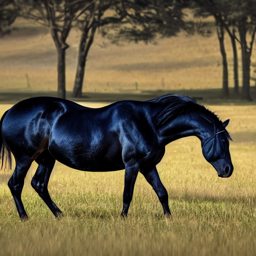

In [9]:
image, seed, frames = generate(prompt, seed=321813746)
show_image(image, seed)

In [10]:
num_inference_steps = 50
scheduler.set_timesteps(num_inference_steps)

In [11]:
# Convert image to latent
latent = image_to_latent(image)
# Noise latent
start_step = 20
seed = 321813746
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(latent)
ts = torch.tensor([scheduler.timesteps[start_step]])
if torch.has_mps:
    latent = latent.to('cpu')
    noise = noise.to('cpu')
#     ts = ts.type(torch.float32).to(torch_device)
noised = scheduler.add_noise(latent, noise, timesteps=ts)
noised = noised.to(torch_device).float()

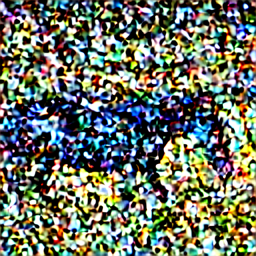

In [12]:
img = image_from_latents(noised)
show_image(img)

In [13]:
def get_noise(prompt, latents, steps=10, guidance=7.5):
    text_embeddings = get_embeddings(prompt)
    unconditioned = get_embeddings()
    text_embeddings = torch.cat([unconditioned, text_embeddings])
    
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # Only process if it's after start_step
        if i > start_step: 
            # Terminat processing if we are over the number of steps
            if i > start_step + steps:
                break
            # Expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                tf = t
                if torch.has_mps:
                    tf = tf.type(torch.float32)
                noise_pred = unet(latent_model_input, tf, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents).prev_sample
    image = image_from_latents(latents)
    return image, latents

0it [00:00, ?it/s]

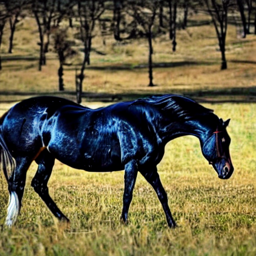

In [22]:
# Move forward to the end from origin with horse
rest = num_inference_steps - start_step
img, latent = get_noise(prompt, noised, steps=rest)
show_image(img)

0it [00:00, ?it/s]

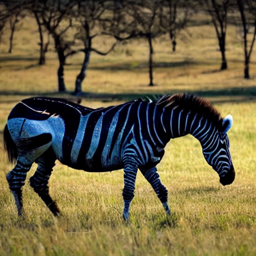

In [23]:
# Move forward to the end from origin with zebra
img, latent = get_noise(edit_prompt, noised, steps=rest)
show_image(img)

0it [00:00, ?it/s]

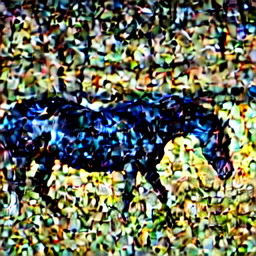

In [24]:
# Move forward a few steps from origin with horse
img, lat_horse = get_noise(prompt, noised, steps=10)
show_image(img)

0it [00:00, ?it/s]

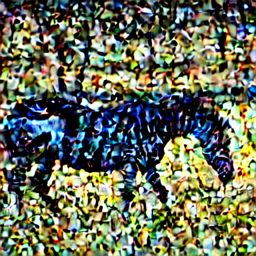

In [26]:
# Move forward a few steps from origin with zebra
img, lat_zebra = get_noise(edit_prompt, noised, steps=10)
show_image(img)

In [27]:
# Get difference between horse and zebra latents
lat_diff = lat_zebra - lat_horse

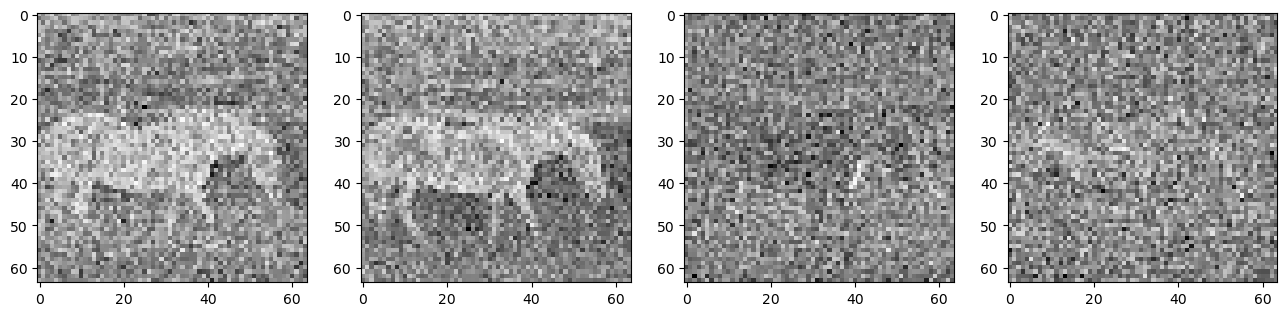

In [28]:
show_latents(lat_horse)

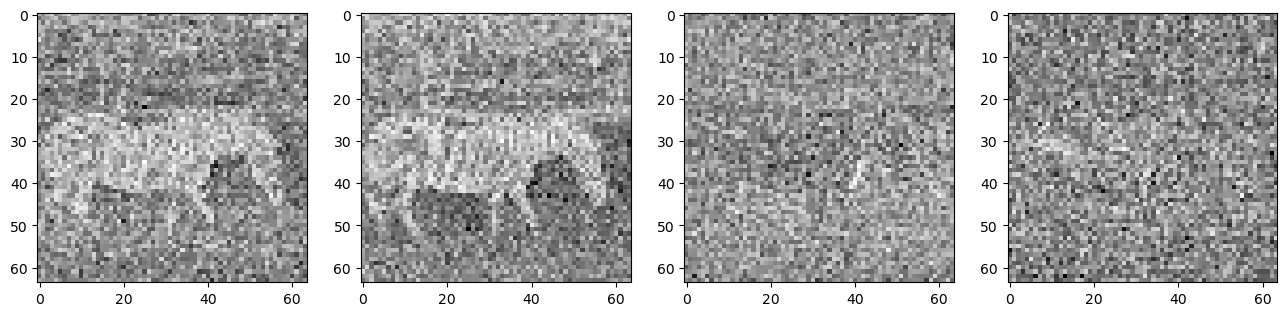

In [29]:
show_latents(lat_zebra)

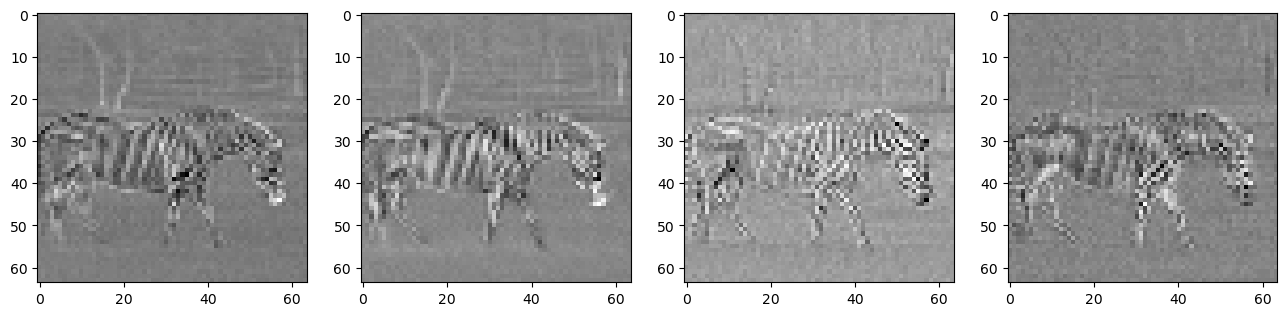

In [30]:
show_latents(lat_diff)

In [31]:
# Get difference between horse and zebra images (rather than latents)
arr_horse = array_from_latents(lat_horse)
arr_zebra = array_from_latents(lat_zebra)
arr_diff = arr_zebra - arr_horse

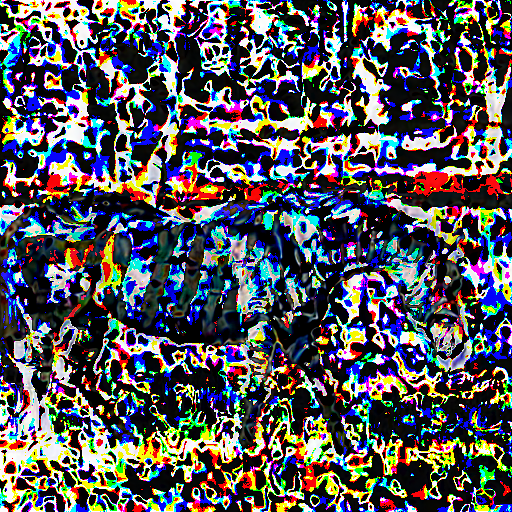

In [32]:
# What does the resulting image look like?
img = Image.fromarray(arr_diff)
img

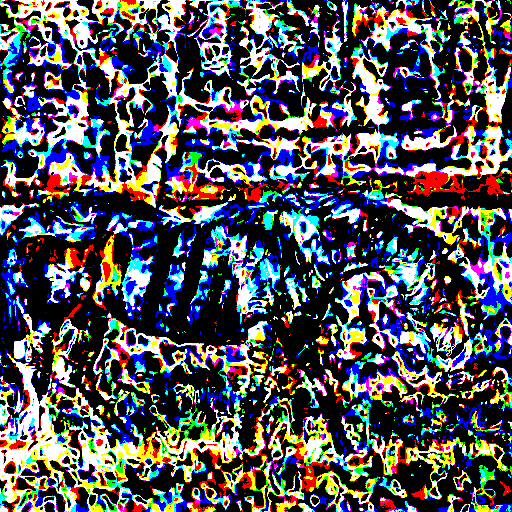

In [48]:
# Try to convert to black and white image
im_bin = np.where(arr_diff > 128, 255, 0).astype('uint8')
# Display difference image
img = Image.fromarray(im_bin)
img

In [46]:
im_bin.shape

(512, 512, 3)

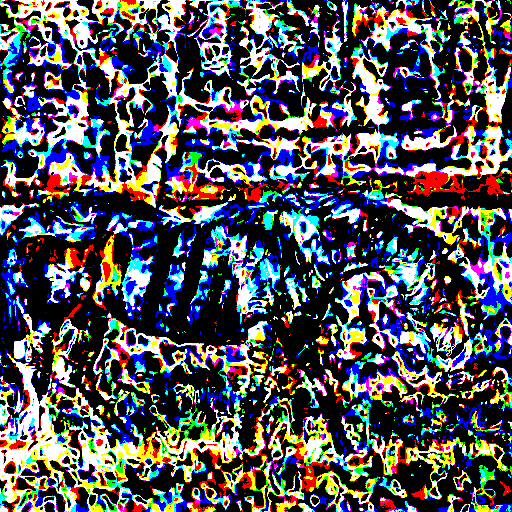

In [108]:
lat = (lat_horse[0][0] + lat_horse[0][1] + lat_horse[0][2] + lat_horse[0][3]) / 4
lat

tensor([[-2.4263e-03, -3.0826e-01, -2.4076e-01,  ...,  1.0052e+00,
         -8.4038e-01, -3.8073e-01],
        [ 1.5214e-01, -3.5834e-01, -5.6134e-01,  ...,  2.7105e-01,
         -8.3497e-01, -3.9272e-04],
        [-1.2694e-01,  2.4101e-01, -2.7501e-02,  ..., -2.5275e-01,
         -5.6125e-03, -3.7752e-01],
        ...,
        [-2.6608e-01,  7.7952e-01,  1.2407e+00,  ...,  7.8967e-01,
          6.7287e-01,  1.3492e+00],
        [ 3.5440e-01,  1.3317e+00,  4.7842e-01,  ...,  1.4770e+00,
          1.0640e-01,  5.0358e-02],
        [ 5.2425e-01, -3.3536e-01, -9.6366e-02,  ..., -3.5891e-02,
         -1.7950e-01,  5.9083e-01]], device='mps:0')

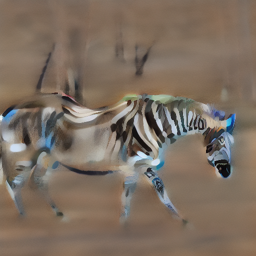

In [60]:
# Show difference image
img = image_from_latents(lat_diff)
show_image(img)

In [64]:
lat = 1 / 0.18215 * lat_diff
with torch.no_grad():
    data = vae.decode(lat).sample

In [78]:
images = (data / 2 + 0.5).clamp(0, 1)
images = images.detach().cpu().permute(0, 2, 3, 1).numpy()
di = images[0]

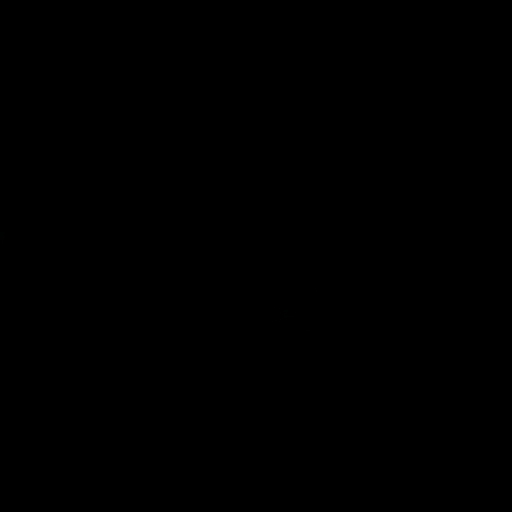

In [89]:
i = np.where(di<0.9, 0, 1)
image = Image.fromarray(i.astype('uint8'))
image

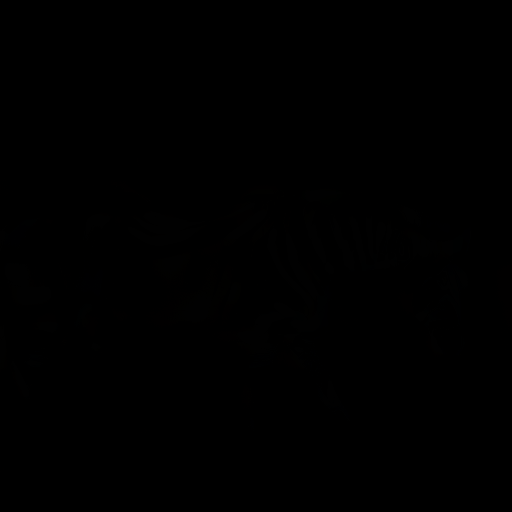

In [41]:
# Convert to black and white image
im_bin = ((image[0] > 0.5) * 255).round().astype("uint8")
im_bin

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [255,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [255,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [  0,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]

In [ ]:
img = Image.fromarray(im_bin)
img

In [ ]:
images = (images * 255).round().astype("uint8")
image = Image.fromarray(images[0]).convert('L')
im_grey = np.array(image)
im_bin = (im_grey > 128) * 255
image = Image.fromarray(np.uint8(im_bin))